<a href="https://colab.research.google.com/github/pprzybyt/article/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from pathlib import Path

# you can change `sentiment` to whatever suits you
project_path = Path("/content/drive/My Drive/Colab Notebooks/sentiment")
project_path.mkdir(parents=True, exist_ok=True)
os.chdir(project_path)  # set working directory to not overwrite any crucial data

# **1. Dataset preparation**
1.6M tweets dataset: https://www.kaggle.com/kazanova/sentiment140 the one in 
Data Explorer section = 227.74 MB

Please download it under `<project_path>/data/training.1600000.processed.noemoticon.csv` on your drive

In [4]:
dataset_path = 'data/training.1600000.processed.noemoticon.csv'
assert Path(dataset_path).exists(), 'You need to download the dataset first'

In [5]:
%%time
import pandas as pd
df = pd.read_csv(
    filepath_or_buffer=dataset_path, 
    encoding="ISO-8859-1", 
    usecols=[0, 5],
    names=['target', 'text'],
    engine='python', 
    error_bad_lines=False,
    )

CPU times: user 8.36 s, sys: 574 ms, total: 8.93 s
Wall time: 10.3 s


In [6]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## **Distribution of labels (0 - negative, 4 - positive)**



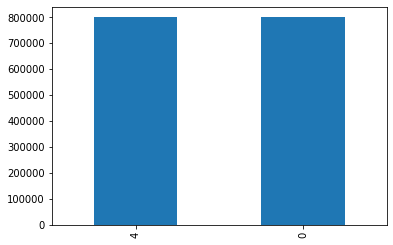

In [7]:
df['target'].value_counts().plot(kind='bar')

## **Data cleanup**



In [8]:
%%time
df['text'] = df['text'] \
.str.replace(r'(?:@|#|https?:|www\.)\S+', '') \
.str.replace(r'[^A-Za-z0-9 ]+', '') \
.str.split() \
.str.join(' ') \
.str.lower()

df['target'] = df['target'].replace(4, 1)


CPU times: user 11.3 s, sys: 560 ms, total: 11.8 s
Wall time: 11.8 s


In [9]:
df.head()

,target,text
0,0,awww thats a bummer you shoulda got david carr...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


## **Data split**


In [10]:
from sklearn.model_selection import train_test_split

TEST_SIZE = .1
RANDOM_STATE = 123

def split_data(test_size: float = TEST_SIZE, random_state: int = RANDOM_STATE):
  X = df['text']
  y = df['target']

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      random_state=random_state,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test


# **2. LogisticRegression approach**


In [11]:
import pathlib
import pickle

models_path = pathlib.Path('models')
filename = 'log_reg'
filename += '.pkl'
# You can customize the model name creation - here a basic approach is shown
log_reg_path = models_path/filename

models_path.mkdir(exist_ok=True)

def save_model(path, *args):
  print(f'Saving model under {path}')
  with open(path, 'wb') as f:
    pickle.dump([*args], f) 

def load_model(path):
  print(f'Loading model from {path}')
  with open(path, 'rb') as f: 
    models = pickle.load(f)
  return models


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

NGRAM_RANGE = 2
MAX_ITER = 10
LOAD = False
TRAIN = True

X_train, X_test, y_train, y_test = split_data()
print(X_train)

if LOAD and log_reg_path.exists():
  print(f'Loading logistic regression model from `{log_reg_path}`')
  vectorizer, log_reg = load_model(log_reg_path)
  X_train = vectorizer.transform(X_train)
else:
  vectorizer = CountVectorizer(ngram_range=(1, NGRAM_RANGE))
  log_reg = LogisticRegression(max_iter=MAX_ITER, random_state=RANDOM_STATE)
  X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

if TRAIN:
  print('Started training... It may take a while, depending on MAX_ITER value')
  log_reg = log_reg.fit(X_train, y_train)
  print('Finished training.')
  save_model(log_reg_path, vectorizer, log_reg)


487541     is cracking on with learning more of the code ...
315807     my home server has finaly packed in well one t...
811173     is in chem going to marys later and meg and bi...
1344143    im doing well i really should tear myself away...
350702           working on my online classes ugh this sucks
                                 ...                        
1096932    4 steps you can do 2 make money while your twe...
1494329                        i missed a step ill do it now
150791     i feel like drinking a moka its kinda late to ...
460927     had far too much wine which has lost me a chun...
1314199                     thanks for the how have you been
Name: text, Length: 1440000, dtype: object
Started training... It may take a while, depending on MAX_ITER value


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Finished training.
Saving model under models/log_reg.pkl


## **Load model**

In [14]:
# checking if model can be restored properly
load_model(log_reg_path)

Loading model from models/log_reg.pkl


[CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 2), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=10,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)]

## **Results**


              precision    recall  f1-score   support

           0       0.72      0.79      0.75    656458
           1       0.81      0.74      0.77    783542

    accuracy                           0.76   1440000
   macro avg       0.76      0.77      0.76   1440000
weighted avg       0.77      0.76      0.77   1440000

              precision    recall  f1-score   support

           0       0.72      0.79      0.75     72952
           1       0.81      0.74      0.77     87048

    accuracy                           0.76    160000
   macro avg       0.76      0.77      0.76    160000
weighted avg       0.77      0.76      0.76    160000



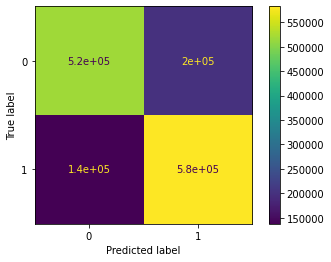

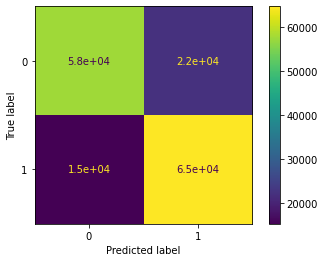

In [15]:
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(log_reg.predict(X_train), y_train))
print(classification_report(log_reg.predict(X_test), y_test))

plot_confusion_matrix(log_reg, X_train, y_train)
plot_confusion_matrix(log_reg, X_test, y_test)

### **Feature importance**


Without any hardcoded information about language semantics the algorithm is able to extract very usefull features. 

In [16]:
features = vectorizer.get_feature_names()

In [17]:
import numpy as np

top_n = 10
positive = np.argsort(log_reg.coef_[0])[::-1][:top_n]
negative = np.argsort(log_reg.coef_[0])[:top_n]

print(f'\n Positive features: \n {[features[x] for x in positive]}')
print(f'\n Negative features: \n {[features[x] for x in negative]}')


 Positive features: 
 ['thanks', 'happy', 'cant wait', 'great', 'awesome', 'nice', 'haha', 'yay', 'thank', 'love']

 Negative features: 
 ['sad', 'miss', 'sorry', 'hate', 'wish', 'sick', 'cant', 'bad', 'sucks', 'didnt']


In [18]:
# TO BE CONTINUED ;)